In [ ]:
# Traffic Congestion Predictor

#  Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV



In [22]:
#  Load the dataset
df = pd.read_csv("dataset.csv")
df.columns = df.columns.str.strip()  # Clean any accidental whitespaces

print("Dataset Loaded Successfully")
df.head()


Dataset Loaded Successfully


,Day,Date,CodedDay,Zone,Weather,Temperature,Traffic
0,Wednesday,01-06-18,3,2,35,17,2
1,Wednesday,01-06-18,3,3,36,16,3
2,Wednesday,01-06-18,3,4,27,25,5
3,Wednesday,01-06-18,3,5,23,23,3
4,Wednesday,01-06-18,3,6,18,42,2


In [23]:
#  Drop non-informative columns
df.drop(columns=['Day', 'Date'], inplace=True)

# Convert 'Weather' to string for encoding
df['Weather'] = df['Weather'].astype(str)

#  One-hot encode categorical feature 'Weather'
df = pd.get_dummies(df, columns=['Weather'], drop_first=True)

# Convert boolean columns (from get_dummies) to int
df = df.astype({col: int for col in df.columns if df[col].dtype == bool})

#   Create synthetic 'Hour' feature from Zone
df['Hour'] = df['Zone'] % 24


#  Convert 5 traffic levels into 3 broader classes
# 1–2 = Low, 3 = Medium, 4–5 =High
def bin_traffic(x):
    if x <= 2:
        return 1  # Low
    elif x == 3:
        return 2  # Medium
    else:
        return 3  # High

df['Traffic_Level'] = df['Traffic'].apply(bin_traffic)
df.head()


,CodedDay,Zone,Temperature,Traffic,Weather_1,Weather_10,Weather_11,Weather_12,Weather_13,Weather_14,...,Weather_45,Weather_46,Weather_47,Weather_5,Weather_6,Weather_7,Weather_8,Weather_9,Hour,Traffic_Level
0,3,2,17,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
1,3,3,16,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,2
2,3,4,25,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,3
3,3,5,23,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
4,3,6,42,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,1


In [24]:
#  Separate features and target
X = df.drop('Traffic', axis=1)
y = df['Traffic_Level']



In [25]:
#  Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
#  Train a Random Forest Classifier with basic tuning
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train_scaled, y_train)

#  Predict
y_pred = clf.predict(X_test_scaled)


In [27]:
#  Accuracy & Classification Report
print(f" Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))


 Accuracy: 1.00

 Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00       118

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



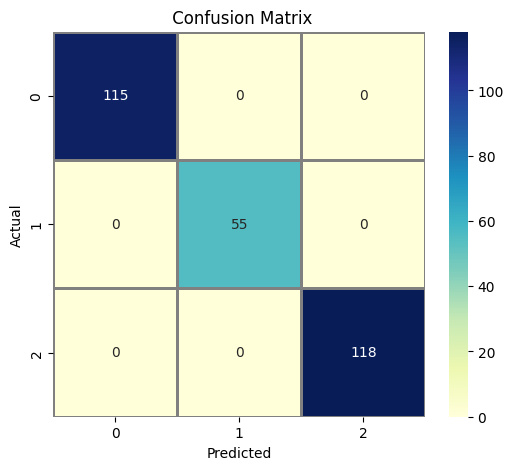

In [28]:
#  Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=1, linecolor='gray')
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_7028\1086838534.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp_df, palette='crest')


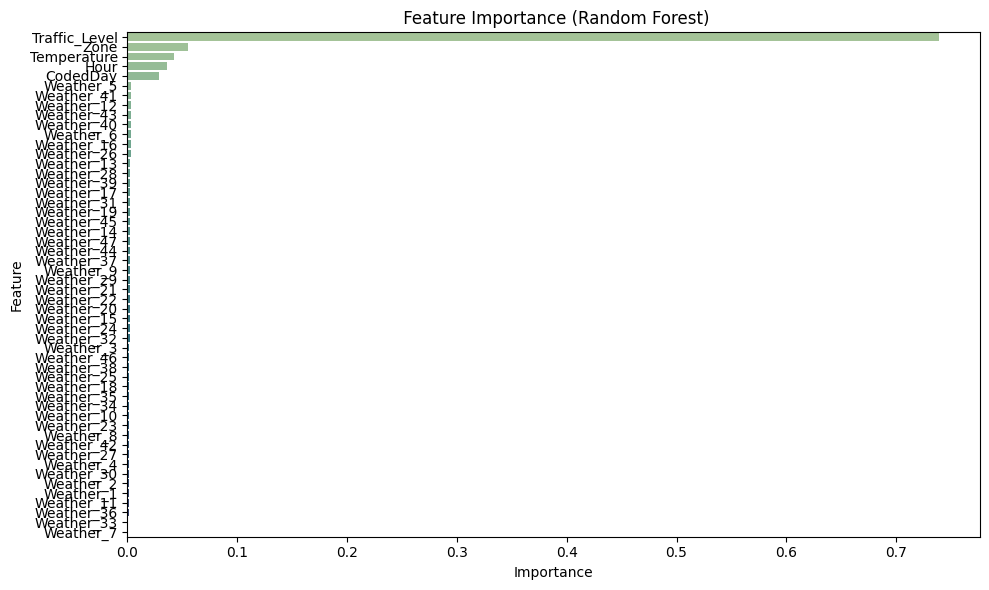

In [29]:
#  Feature Importance Plot
importances = clf.feature_importances_
features = X.columns

imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
imp_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='crest')
plt.title(" Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


In [30]:
# Save predictions with actuals to CSV
result_df = X_test.copy()
result_df['Actual_Traffic'] = y_test.values
result_df['Predicted_Traffic'] = y_pred
result_df.to_csv("traffic_predictions_output.csv", index=False)
print("Predictions saved to 'traffic_predictions_output.csv'")


Predictions saved to 'traffic_predictions_output.csv'


C:\Users\DELL\AppData\Local\Temp\ipykernel_7028\2875550595.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette='Set2')


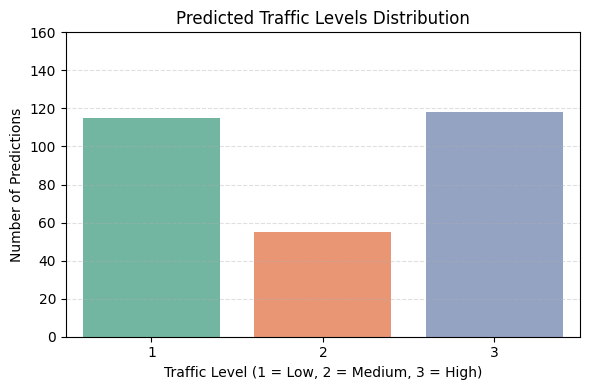

In [36]:
# Count of Predicted Traffic Levels (1, 2, 3)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred, palette='Set2')

plt.title("Predicted Traffic Levels Distribution")
plt.xlabel("Traffic Level (1 = Low, 2 = Medium, 3 = High)")
plt.ylabel("Number of Predictions")
plt.ylim(0, 160)  # adjustable
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_7028\4167849831.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_zones.index.astype(str), y=top_zones.values, palette='coolwarm')


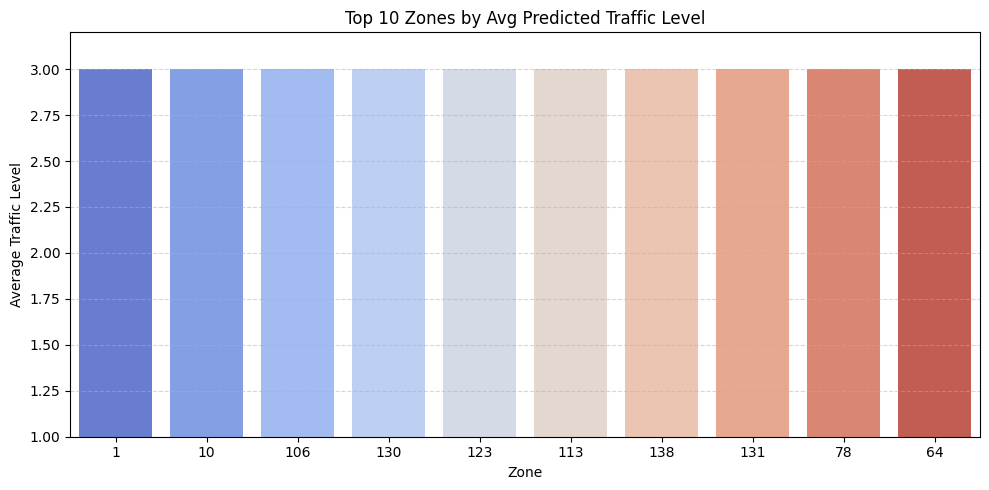

In [37]:
# 📊Average Predicted Traffic Level for Top 10 Zones (sorted by traffic)
top_zones = result_df.groupby('Zone')['Predicted_Traffic_Level'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_zones.index.astype(str), y=top_zones.values, palette='coolwarm')

plt.title("Top 10 Zones by Avg Predicted Traffic Level")
plt.xlabel("Zone")
plt.ylabel("Average Traffic Level")
plt.ylim(1, 3.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


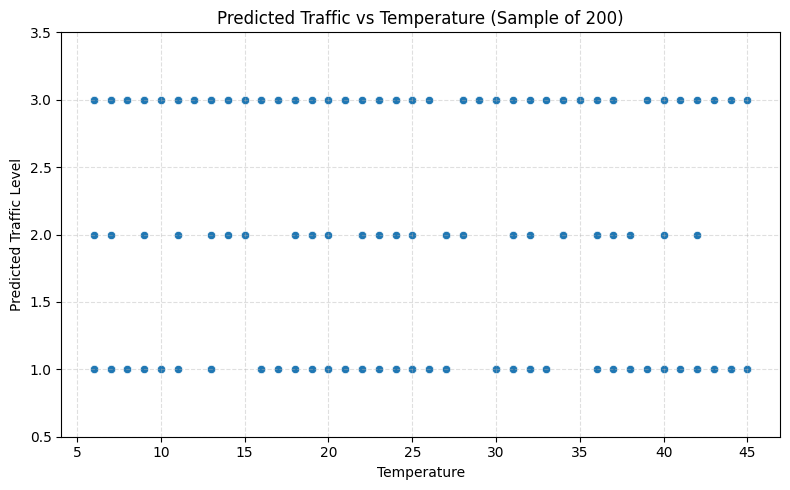

In [38]:
#  Predicted Traffic vs Temperature 
sample_df = result_df.sample(200, random_state=42)

plt.figure(figsize=(8, 5))
sns.scatterplot(x='Temperature', y='Predicted_Traffic_Level', data=sample_df)

plt.title("Predicted Traffic vs Temperature (Sample of 200)")
plt.xlabel("Temperature")
plt.ylabel("Predicted Traffic Level")
plt.ylim(0.5, 3.5)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


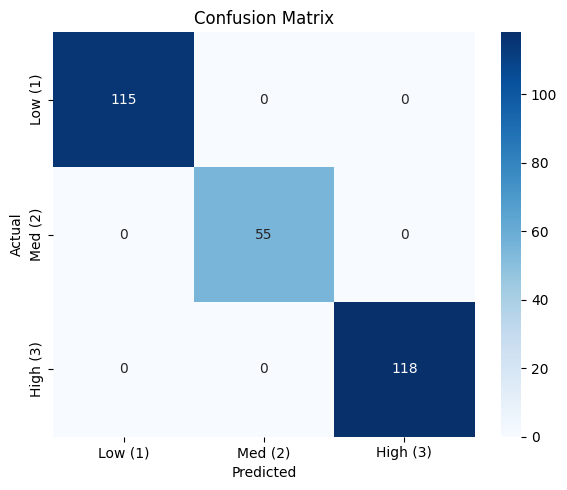

In [39]:
#  Confusion matrix with labels
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['Low (1)', 'Med (2)', 'High (3)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_7028\1397985345.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


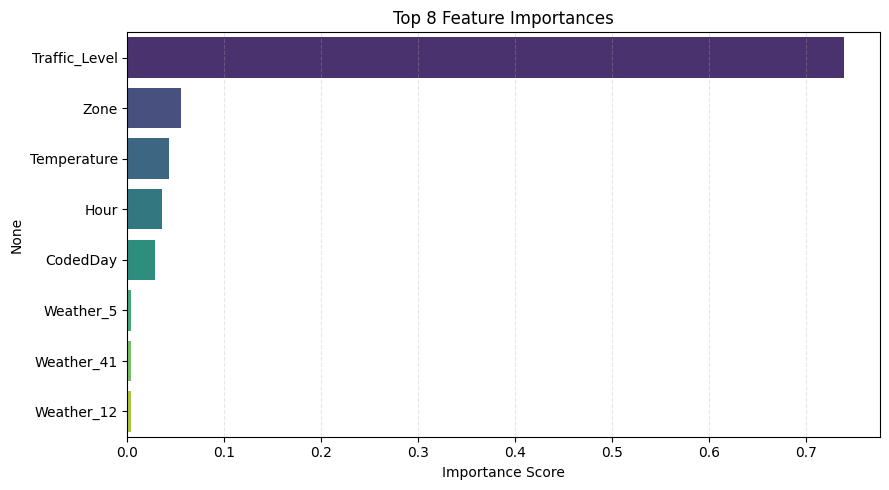

In [40]:
# Feature Importance
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
top_features = feat_importances.sort_values(ascending=False).head(8)

plt.figure(figsize=(9, 5))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")

plt.title("Top 8 Feature Importances")
plt.xlabel("Importance Score")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
